L2 Cartpole

In [3]:
!pip install mkl


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.6/187.6 MB 1.1 MB/s eta 0:00:00m eta 0:00:010:00:04
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 758.3/758.3 kB 1.2 MB/s eta 0:00:001.2 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 640.9/640.9 kB 1.2 MB/s eta 0:00:00m eta 0:00:010:0101
DEPRECATION: celery 5.0.5 has a non-standard dependency specifier pytz>dev. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of celery or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: pandas 0.23.0 has a non-standard dependency specifier pytz>=2011k. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pandas or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/

In [12]:
!pip install matplotlib

DEPRECATION: celery 5.0.5 has a non-standard dependency specifier pytz>dev. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of celery or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: pandas 0.23.0 has a non-standard dependency specifier pytz>=2011k. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pandas or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

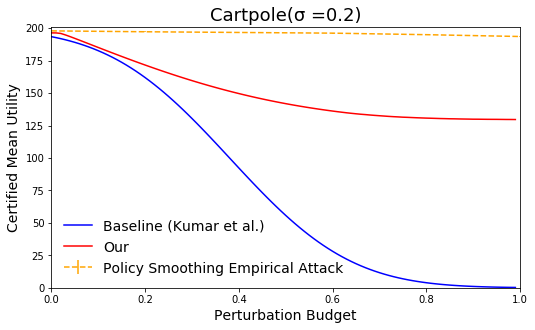

In [18]:
import scipy.special
from scipy.stats import norm, binom_test,sem
from statsmodels.stats.proportion import proportion_confint
import math
import numpy as np
import torch
import matplotlib.pyplot as plt
import cvxpy as cp
import warnings
from sklearn import preprocessing
import time
warnings.filterwarnings("ignore")
def get_cvar_cert_time_t(estimate, t, eps,sigma):
	erf = scipy.special.erf(math.sqrt(t+1) * eps/(2*math.sqrt(2)*sigma))
	cvar = 1. if estimate > erf else estimate/erf
	return cvar * erf

def get_exact_time_t(estimate, t, eps,sigma):
	return norm.cdf(norm.ppf(estimate) - math.sqrt(t+1) * eps/(sigma))

def _lower_confidence_bound(NA: int, N: int, alpha: float) -> float:
    return proportion_confint(NA, N, alpha=2 * alpha, method="beta")[0]
def get_exact_total(estimate, eps,sigma):
	return norm.cdf(norm.ppf(estimate) -  eps/(sigma))

def _hoeffding_lcb(mean: float,  N: int, alpha: float) -> float:
	return max(mean - math.sqrt(math.log(1./alpha)/(2*N)),0)
def get_hs_bound(sigma,norm_bound:float, beta:float):
        
        a = norm_bound/(2*sigma) - np.log(beta)*sigma/(2*norm_bound)
        b = -norm_bound/(2*sigma) - np.log(beta)*sigma/(2*norm_bound)
        HS_bound = norm.cdf(a)-beta*norm.cdf(b)-max(1-beta,0)
        return max(HS_bound,0)



def optimize(epsilon_0: float,  beta_0 : float, phi,minim):
    
    
    
    N=len(phi)
    lambda_0 = cp.Variable(1)
    
    k=cp.Variable(1)
    u_0=k+lambda_0*epsilon_0-(phi)
    
    
    f_0_r = cp.maximum(beta_0*u_0,0)+ lambda_0*cp.maximum(1-beta_0,0)
    mean=cp.sum(f_0_r)/N
    r=mean
    
    #for i in range(n_iter):
    prob = k-r
    cp.Problem(cp.Maximize(prob),[lambda_0>=0,prob>=0,k<=lambda_0*(1-epsilon_0)+min(phi)]).solve(solver=cp.ECOS) #k<=lambda_0*(1-epsilon_0)+min(phi)
    #print(k.value,lambda_0.value,lambda_1.value)
    return  k.value,lambda_0.value
    #return prob.value
def variance(mean,z):
    var=[]
    N=len(z)
    for i in range(N):
        var.append((z[i]-mean)**2)
    final_var=np.sqrt(np.sum(var)/N)
    return final_var
    
epsilon_PAC=0.01
plt.figure(figsize=(8.4,4.8))
colors = ['blue','cornflowerblue','deepskyblue','cadetblue']
shapes = ['-', '--', '-.', ':']
for j,sigma in enumerate([0.2]):#0.4,0.6,0.8]):
    data = torch.tensor(torch.load('cartpole_multiframe_sigma_'+str(sigma)+'/best_model.zip_evals_10000.pth'))
    #states=torch.tensor(torch.load('cartpole_multiframe_sigma_'+str(sigma)+'/best_model.zipinitial_state.pth'))
    
    probs = torch.tensor(list([(data > i).sum()/10000. for i in range(200)]))
    #probs_lb = [ _lower_confidence_bound(int(i*10000.),10000, .01/200) for i in probs]
    
    probs_lb = [ _hoeffding_lcb(i,10000, .01/200) for i in probs]
    print(probs)
    print(probs_lb)
    
    samples=1000
    
    #samples=int(2/epsilon_PAC*(np.log(1/0.05)+np.shape(states)[1]))
    
    vals = []
    var_our = []
    N=len(data)
    data=data.numpy()
    vals_crop =[]
    
    min_d= min(data)
    time_our=[]
    time_bs=[]
    for eps in np.arange(0,1.0, 0.01):#1.01
        beta_0=1.1
        '''
        if eps<0.25:
            beta_0 = 1#1.7 for 0.2
        elif eps<0.45:
            beta_0=1.7
        else:
            beta_0=3#1.7 for 0.3
        '''
        epsilon_0 = get_hs_bound(sigma,norm_bound=eps,beta=beta_0)
        # bound for beta=8
        avg = 0
        accum = 0
        #var_our.append(optimize(epsilon_0,epsilon_1,beta_0,beta_1,data[:samples]))
        start=time.time()
        k,lambda_0=optimize(epsilon_0,beta_0,data[:samples],min_d)
        u_0=k+epsilon_0*lambda_0-data
        f_0_r = np.maximum(beta_0*u_0,0)+ lambda_0*np.maximum(1-beta_0,0)
        #for i in range(n_iter):
        result= k-(np.mean(np.array(f_0_r))+(max(f_0_r)-min(f_0_r))*math.sqrt(math.log(2/0.01)/(2*N)))
        var_our.append(result)
        end=time.time()-start
        time_our.append(end)
        st=time.time()
        for i in range(200):
            avg += probs[(199-i)]
            accum += get_exact_total(probs_lb[(199-i)],eps, sigma)
        vals.append(accum)
        en=time.time()-st
        time_bs.append(en)
        L=(np.max(data)-np.min(data))/sigma *math.sqrt(2/math.pi)
        crop=np.mean(data)-L*eps*math.sqrt(200)
        vals_crop.append(crop)
    print('Our time is',np.mean(time_our[1:]),'baseline time is',np.mean(time_bs[1:]))
    plt.plot(np.arange(0.00,1.00, 0.01),vals,color=colors[j],linestyle=shapes[j],  label= "Baseline (Kumar et al.)")  #"Policy Smoothing: Certified\nLower Bound (σ = " + str(sigma) +')')
    plt.plot(np.arange(0.00,1.00, 0.01),var_our,color='red',linestyle=shapes[j],  label= "Our") 
    #plt.plot(np.arange(0.00,1.00, 0.01),vals_crop,color='green',linestyle=shapes[j],  label= "Baseline(CROP)")

styles = ['-.','--',":"]
attack_mags_nonzero = [0.2,0.6,0.8,1.0]#
for j,sigma in enumerate([0.2]):#,0.4]):
    attack_vals =  [torch.tensor(torch.load('cartpole_multiframe_sigma_'+str(sigma)+'/best_model.zip_evals_10000.pth')).float().mean().item()]
    attack_sems = [sem(torch.tensor(torch.load('cartpole_multiframe_sigma_'+str(sigma)+'/best_model.zip_evals_10000.pth')))]
    for attack_mag in attack_mags_nonzero:
        attack_val = None
        attack_sem = None
        for i,thresh in enumerate([0.0]):
            cur_val = (torch.tensor( torch.load('cartpole_multiframe_sigma_'+str(sigma)+'/best_model.zip_evals_1000_smooth_attack_eps_'+str(attack_mag)+'_attack_step_count_multiplier_2_attack_step_0.01_threshold_'+str(thresh)+'_num_smoothing_points_128.pth')).float().mean().item())
            if (attack_val is None or cur_val < attack_val):
                attack_val = cur_val
                attack_sem = (sem(torch.tensor( torch.load('cartpole_multiframe_sigma_'+str(sigma)+'/best_model.zip_evals_1000_smooth_attack_eps_'+str(attack_mag)+'_attack_step_count_multiplier_2_attack_step_0.01_threshold_'+str(thresh)+'_num_smoothing_points_128.pth'))))
        attack_vals.append(attack_val)
        attack_sems.append(attack_sem)
    attack_mags = [0] + attack_mags_nonzero
    
    plt.errorbar([x for x in attack_mags],attack_vals,  yerr= attack_sems, color='orange',  linestyle ="--",label="Policy Smoothing Empirical Attack")
plt.legend(loc='lower left', fontsize=14,frameon=False)

plt.title('Cartpole(σ =0.2)', fontsize=18)
plt.xlim(0,1.)
plt.xlabel('Perturbation Budget', fontsize=14)
plt.ylim(0,201)
plt.ylabel('Certified Mean Utility', fontsize=14)
plt.savefig('cartpole0.2.pdf', dpi=400,bbox_inches='tight')
plt.show()

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9999, 0.9999, 0.9998, 0.9998, 0.9997, 0.9996, 0.9994, 0.9990,
        0.9987, 0.9985, 0.9981, 0.9978, 0.9974, 0.9970, 0.9967, 0.9963, 0.9956,
        0.9950, 0.9947, 0.9942, 0.9932, 0.9918, 0.9916, 0.9909, 0.9901, 0.9895,
        0.9884, 0.9876, 0.9866, 0.9857, 0.9846, 0.9836, 0.9823, 0.9815, 0.9804,
        0.9796, 0.9789, 0.9782, 0.9773, 0.9765, 0.9755, 0.9742, 0.9731, 0.9712,
        0.9702, 0.9692, 0.9683, 0.9671, 0.9655, 0.9646, 0.9637, 0.9623, 0.9603,
        0.9581, 0.9560, 0.9540, 0.9518, 0.9499, 0.9480, 0.9449, 0.9416, 0.9367,
        0.9330, 0.9293, 0.9245, 0.9215, 0.9158, 0.9110, 0.9056, 0.9013, 0.8963,
        0.8919, 0.8860, 0.8808, 0.8762, 0.8709, 0.8653, 0.8606, 0.8540, 0.8479,
        0.8412, 0.8351, 0.8304, 0.8248, 0.8181, 0.8117, 0.8047, 0.7986, 0.7920,
        0.7860, 0.7803, 0.7740, 0.7683, 0.7620, 0.7543, 0.7486, 0.7426, 0.7365,
        0.7306, 0.7242, 0.7188, 0.7115, 

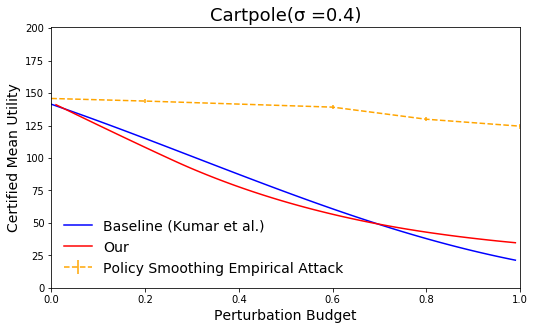

In [20]:
import scipy.special
from scipy.stats import norm, binom_test,sem
from statsmodels.stats.proportion import proportion_confint
import math
import numpy as np
import torch
import matplotlib.pyplot as plt
import cvxpy as cp
import warnings
from sklearn import preprocessing
import time
warnings.filterwarnings("ignore")
def get_cvar_cert_time_t(estimate, t, eps,sigma):
	erf = scipy.special.erf(math.sqrt(t+1) * eps/(2*math.sqrt(2)*sigma))
	cvar = 1. if estimate > erf else estimate/erf
	return cvar * erf

def get_exact_time_t(estimate, t, eps,sigma):
	return norm.cdf(norm.ppf(estimate) - math.sqrt(t+1) * eps/(sigma))

def _lower_confidence_bound(NA: int, N: int, alpha: float) -> float:
    return proportion_confint(NA, N, alpha=2 * alpha, method="beta")[0]
def get_exact_total(estimate, eps,sigma):
	return norm.cdf(norm.ppf(estimate) -  eps/(sigma))

def _hoeffding_lcb(mean: float,  N: int, alpha: float) -> float:
	return max(mean - math.sqrt(math.log(1./alpha)/(2*N)),0)
def get_hs_bound(sigma,norm_bound:float, beta:float):
        
        a = norm_bound/(2*sigma) - np.log(beta)*sigma/(2*norm_bound)
        b = -norm_bound/(2*sigma) - np.log(beta)*sigma/(2*norm_bound)
        HS_bound = norm.cdf(a)-beta*norm.cdf(b)-max(1-beta,0)
        return max(HS_bound,0)



def optimize(epsilon_0: float,  beta_0 : float, phi,minim):
    
    
    
    N=len(phi)
    lambda_0 = cp.Variable(1)
    
    k=cp.Variable(1)
    u_0=k+lambda_0*epsilon_0-(phi)
    
    
    f_0_r = cp.maximum(beta_0*u_0,0)+ lambda_0*cp.maximum(1-beta_0,0)
    mean=cp.sum(f_0_r)/N
    r=mean
    
    #for i in range(n_iter):
    prob = k-r
    cp.Problem(cp.Maximize(prob),[lambda_0>=0,prob>=0,k<=lambda_0*(1-epsilon_0)+min(phi)]).solve(solver=cp.ECOS) #k<=lambda_0*(1-epsilon_0)+min(phi)
    #print(k.value,lambda_0.value,lambda_1.value)
    return  k.value,lambda_0.value
    #return prob.value
def variance(mean,z):
    var=[]
    N=len(z)
    for i in range(N):
        var.append((z[i]-mean)**2)
    final_var=np.sqrt(np.sum(var)/N)
    return final_var
    
epsilon_PAC=0.01
plt.figure(figsize=(8.4,4.8))
colors = ['blue','cornflowerblue','deepskyblue','cadetblue']
shapes = ['-', '--', '-.', ':']
for j,sigma in enumerate([0.4]):#0.4,0.6,0.8]):
    data = torch.tensor(torch.load('cartpole_multiframe_sigma_'+str(sigma)+'/best_model.zip_evals_10000.pth'))
    #states=torch.tensor(torch.load('cartpole_multiframe_sigma_'+str(sigma)+'/best_model.zipinitial_state.pth'))
    
    probs = torch.tensor(list([(data > i).sum()/10000. for i in range(200)]))
    #probs_lb = [ _lower_confidence_bound(int(i*10000.),10000, .01/200) for i in probs]
    
    probs_lb = [ _hoeffding_lcb(i,10000, .01/200) for i in probs]
    print(probs)
    print(probs_lb)
    
    samples=1000
    
    #samples=int(2/epsilon_PAC*(np.log(1/0.05)+np.shape(states)[1]))
    
    vals = []
    var_our = []
    N=len(data)
    data=data.numpy()
    vals_crop =[]
    
    min_d= min(data)
    time_our=[]
    time_bs=[]
    for eps in np.arange(0,1.0, 0.01):#1.01
        beta_0=1
        '''
        if eps<0.25:
            beta_0 = 1#1.7 for 0.2
        elif eps<0.45:
            beta_0=1.7
        else:
            beta_0=3#1.7 for 0.3
        '''
        epsilon_0 = get_hs_bound(sigma,norm_bound=eps,beta=beta_0)
        # bound for beta=8
        avg = 0
        accum = 0
        #var_our.append(optimize(epsilon_0,epsilon_1,beta_0,beta_1,data[:samples]))
        start=time.time()
        k,lambda_0=optimize(epsilon_0,beta_0,data[:samples],min_d)
        u_0=k+epsilon_0*lambda_0-data
        f_0_r = np.maximum(beta_0*u_0,0)+ lambda_0*np.maximum(1-beta_0,0)
        #for i in range(n_iter):
        result= k-(np.mean(np.array(f_0_r))+(max(f_0_r)-min(f_0_r))*math.sqrt(math.log(2/0.01)/(2*N)))
        var_our.append(result)
        end=time.time()-start
        time_our.append(end)
        st=time.time()
        for i in range(200):
            avg += probs[(199-i)]
            accum += get_exact_total(probs_lb[(199-i)],eps, sigma)
        vals.append(accum)
        en=time.time()-st
        time_bs.append(en)
        L=(np.max(data)-np.min(data))/sigma *math.sqrt(2/math.pi)
        crop=np.mean(data)-L*eps*math.sqrt(200)
        vals_crop.append(crop)
    print('Our time is',np.mean(time_our[1:]),'baseline time is',np.mean(time_bs[1:]))
    plt.plot(np.arange(0.00,1.00, 0.01),vals,color=colors[j],linestyle=shapes[j],  label= "Baseline (Kumar et al.)")  #"Policy Smoothing: Certified\nLower Bound (σ = " + str(sigma) +')')
    plt.plot(np.arange(0.00,1.00, 0.01),var_our,color='red',linestyle=shapes[j],  label= "Our") 
    #plt.plot(np.arange(0.00,1.00, 0.01),vals_crop,color='green',linestyle=shapes[j],  label= "Baseline(CROP)")

styles = ['-.','--',":"]
attack_mags_nonzero = [0.2,0.6,0.8,1.0]#
for j,sigma in enumerate([0.4]):#,0.4]):
    attack_vals =  [torch.tensor(torch.load('cartpole_multiframe_sigma_'+str(sigma)+'/best_model.zip_evals_10000.pth')).float().mean().item()]
    attack_sems = [sem(torch.tensor(torch.load('cartpole_multiframe_sigma_'+str(sigma)+'/best_model.zip_evals_10000.pth')))]
    for attack_mag in attack_mags_nonzero:
        attack_val = None
        attack_sem = None
        for i,thresh in enumerate([0.0]):
            cur_val = (torch.tensor( torch.load('cartpole_multiframe_sigma_'+str(sigma)+'/best_model.zip_evals_1000_smooth_attack_eps_'+str(attack_mag)+'_attack_step_count_multiplier_2_attack_step_0.01_threshold_'+str(thresh)+'_num_smoothing_points_128.pth')).float().mean().item())
            if (attack_val is None or cur_val < attack_val):
                attack_val = cur_val
                attack_sem = (sem(torch.tensor( torch.load('cartpole_multiframe_sigma_'+str(sigma)+'/best_model.zip_evals_1000_smooth_attack_eps_'+str(attack_mag)+'_attack_step_count_multiplier_2_attack_step_0.01_threshold_'+str(thresh)+'_num_smoothing_points_128.pth'))))
        attack_vals.append(attack_val)
        attack_sems.append(attack_sem)
    attack_mags = [0] + attack_mags_nonzero
    
    plt.errorbar([x for x in attack_mags],attack_vals,  yerr= attack_sems, color='orange',  linestyle ="--",label="Policy Smoothing Empirical Attack")
plt.legend(loc='lower left', fontsize=14,frameon=False)

plt.title('Cartpole(σ =0.4)', fontsize=18)
plt.xlim(0,1.)
plt.xlabel('Perturbation Budget', fontsize=14)
plt.ylim(0,201)
plt.ylabel('Certified Mean Utility', fontsize=14)
plt.savefig('cartpole0.4.pdf', dpi=400,bbox_inches='tight')
plt.show()

L0 Cartpole

0.0
1.5231612662023448
3.0463225324046896
4.569483798607035
6.092645064809379
7.615806331011724
9.13896759721407
10.662128863416413
12.185290129618759
13.708451395821104
15.231612662023448
0.0
0.5995431194434742
1.1990862388869483
1.7986293583304225
2.3981724777738966
2.997715597217371
3.597258716660845
4.196801836104319
4.796344955547793
5.395888074991268
5.995431194434742


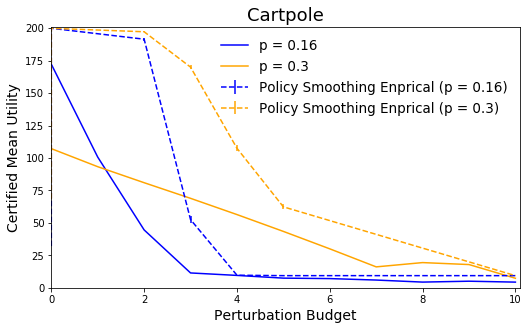

In [34]:

import scipy.special
from scipy.stats import norm, binom_test,sem
from statsmodels.stats.proportion import proportion_confint
import math
import numpy as np
import torch
import matplotlib.pyplot as plt
import cvxpy as cp
import warnings
from sklearn import preprocessing
from scipy.interpolate import interp1d
#from nevergrad.optimization import optimizerlib
from scipy.ndimage import gaussian_filter1d
warnings.filterwarnings("ignore")
def get_cvar_cert_time_t(estimate, t, eps,sigma):
	erf = scipy.special.erf(math.sqrt(t+1) * eps/(2*math.sqrt(2)*sigma))
	cvar = 1. if estimate > erf else estimate/erf
	return cvar * erf

def get_exact_time_t(estimate, t, eps,sigma):
	return norm.cdf(norm.ppf(estimate) - math.sqrt(t+1) * eps/(sigma))

def _lower_confidence_bound(NA: int, N: int, alpha: float) -> float:
    return proportion_confint(NA, N, alpha=2 * alpha, method="beta")[0]
def get_exact_total(estimate, eps,sigma):
	return norm.cdf(norm.ppf(estimate) -  eps/(sigma))

def _hoeffding_lcb(mean: float,  N: int, alpha: float) -> float:
	return max(mean - math.sqrt(math.log(1./alpha)/(2*N)),0)
def get_hs_bound(p:float,norm_bound:float, a:float,n:int):
  '''
  q=1-p
  h=(a/(a-1))*np.log(p)-((1-a)/(a-1))*np.log(q/(n-1))
  print(h)
  h2=norm_bound*h
  s=(1-a)/(a-1)*np.log(q/(n-1)) 
  h3=h2+200*(s+1/(a-1)*np.log(2))
  print(h3)
  return
  '''
  q=1-p
  hs1=p*(q/((n-1)*p))**a
  hs2= hs1+(q/(n-1))*((n-1)*p/q)**a+(n-2)/(n-1)*q
  hs=np.log(hs2)/(a-1)
  return hs*norm_bound
import numpy as np

from scipy.optimize import minimize, LinearConstraint
def optimize_new(epsilon_0: float,  beta_0 : float, phi,minim):
    N=len(phi)
    lambda_0 = cp.Variable(1)
    
    
    k=cp.Variable(1)
    u_0=k+lambda_0*epsilon_0-(phi)
    
    
    f_0_r = cp.maximum(beta_0*u_0,0)+ lambda_0*cp.maximum(1-beta_0,0)
    mean=cp.sum(f_0_r)/N
    r=mean
    
    #for i in range(n_iter):
    prob = k-r
    cp.Problem(cp.Maximize(prob),[lambda_0>=0,prob>=0,k<=lambda_0*(1-epsilon_0)+minim]).solve(solver=cp.ECOS) #k<=lambda_0*(1-epsilon_0)+min(phi)
    #print(k.value,lambda_0.value,lambda_1.value)
    return  k.value,lambda_0.value
    #return prob.value
def objective(x, beta_0,epsilon_0, phi, N):
    lambda_0, b= x
    if beta_0<1:
      f_0_r = (b*lambda_0 + lambda_0 * epsilon_0 - phi)
      h = (f_0_r / -beta_0) ** (beta_0 / (beta_0 - 1))
      f = -lambda_0 + (lambda_0 ** (1 / 1-beta_0))*(1-beta_0) * h
      r = np.sum(f) / N
      prob = b * lambda_0 - r
    else:
      u_0 = (b*lambda_0 + lambda_0 * epsilon_0 - phi)
      f_0_r = np.maximum(u_0, 0)
      h = (f_0_r / beta_0) ** (beta_0 / (beta_0 - 1))
      f = lambda_0 + (lambda_0 ** (1 / 1-beta_0))*(beta_0 - 1) * h
      R=np.max(f)-np.min(f)
      r=(np.mean(np.array(f))+(R)*math.sqrt(math.log(2/0.01)/(2*N)))
      #r = np.sum(f) / N
      prob = b * lambda_0 - r
    return -prob  # Minimize the negative of the objective for maximization

def optimize(epsilon_0, phi, initial_guess,beta_0):
    N = len(phi)
      # 0.5, 5 #0.1,1
    bounds = [(0,None), (None, None)]  # Bounds for lambda_0, b, and beta_0  #np.min(phi)/(initial_guess[1]+epsilon_0)
    
    
    # Perform optimization with the initial guess
    result = minimize(objective, initial_guess, args=(beta_0,epsilon_0, np.array(phi), N), bounds=bounds, method='L-BFGS-B')# CG L-BFGS-B

    # Iteratively refine the initial guess until the objective is close to the target_prob
    optimal_lambda_0, optimal_b = result.x
    return optimal_lambda_0, optimal_b
def variance(mean,z):
    var=[]
    N=len(z)
    for i in range(N):
        var.append((z[i]-mean)**2)
    final_var=np.sum(var)/N
    return final_var  
epsilon_PAC=0.01
plt.figure(figsize=(8.4,4.8))
colors = ['blue','orange','cornflowerblue','deepskyblue','cadetblue']
shapes = ['-', '--', '-.', ':']
for j,p in enumerate([0.16,0.3]):#0.4,0.6,0.8]):
    data = torch.tensor(torch.load('cartpole_multiframe_ef_'+str(p)+'_sigma_0.0/best_model.zip10000.pth'))
    #states=torch.tensor(torch.load('cartpole_multiframe_sigma_'+str(sigma)+'/best_model.zipinitial_state.pth'))
    

    
    samples=4000
    
    #samples=int(2/epsilon_PAC*(np.log(1/0.05)+np.shape(states)[1]))
    
    vals = []
    var_our = []
    N=len(data)
    data=data.numpy()
    vals_crop =[]
    for eps in np.arange(0.0,11.0, 1.0):#1.01
        if p==0.16:
          beta_0=2.27#2.15
          initial_guess = [0.5,10]
        else:
          beta_0=2.23#2.1
          
          initial_guess = [0.4,15] #0.4 15
        
        epsilon_0 = get_hs_bound(1-p,eps,beta_0,2)
        print(epsilon_0)
        # bound for beta=8
        avg = 0
        accum = 0
        
        #var_our.append(optimize(epsilon_0,epsilon_1,beta_0,beta_1,data[:samples]))
        
        lambda_0,k=optimize(epsilon_0,data[:samples],initial_guess,beta_0)
        #print(lambda_0,k,beta_0)
        if beta_0<1:
          f_0_r = (k*lambda_0 + lambda_0 * epsilon_0 - data)
          h = (f_0_r / -beta_0) ** (beta_0 / (beta_0 - 1))
          f = -lambda_0 + (lambda_0 ** (1 / 1-beta_0))*(1-beta_0) * h
        else:
          u_0 = (k*lambda_0 + lambda_0 * epsilon_0 - data)
          f_0_r = np.maximum(u_0, 0)
          
          h = (f_0_r / beta_0) ** (beta_0 / (beta_0 - 1))
          #print(h)
          f = lambda_0 + (lambda_0 ** (1 / 1-beta_0))*(beta_0 -1) * h
        #for i in range(n_iter):
        reward = f
        ave_reward=np.mean(np.array(reward))
        var=variance(ave_reward,np.array(reward))
        R=max(reward)-min(reward)
        upper_bound_E= ave_reward+(R)*math.sqrt(math.log(2/0.01)/(2*N))#+math.sqrt(2*var**2*math.log(3/0.01)/N)+3*R*math.log(3/0.01)/N
        result=k*lambda_0-upper_bound_E
        #print(result)
        var_our.append(result)

    
    #y=gaussian_filter1d(var_our, sigma=0.4) #var_our
    plt.plot(np.arange(0.00,11.0, 1.0),var_our,color=colors[j],linestyle='-',  label= "p = " + str(p)) 
    

'''
attack_mags_nonzero = [0.2,0.4,0.6,0.8,1.0]

attack_vals =  [torch.tensor(torch.load('cartpole_multiframe_sigma_0.0/best_model.zip_evals_10000.pth')).float().mean().item()]
attack_sems = [sem(torch.tensor(torch.load('cartpole_multiframe_sigma_0.0/best_model.zip_evals_10000.pth')))]
for attack_mag in attack_mags_nonzero:
	attack_val = None
	attack_sem = None
	for i,thresh in enumerate([4.,6.,8.,10.]):
		cur_val = (torch.tensor( torch.load('cartpole_multiframe_sigma_0.0/best_model.zip_evals_1000_eps_'+str(attack_mag)+'_attack_step_count_multiplier_2_attack_step_0.01_threshold_'+str(thresh)+'.pth')).float().mean().item())
		if (attack_val is None or cur_val < attack_val):
			attack_val = cur_val
			attack_sem = (sem(torch.tensor( torch.load('cartpole_multiframe_sigma_0.0/best_model.zip_evals_1000_eps_'+str(attack_mag)+'_attack_step_count_multiplier_2_attack_step_0.01_threshold_'+str(thresh)+'.pth'))))
	attack_vals.append(attack_val)
	attack_sems.append(attack_sem)
attack_mags = [0] + attack_mags_nonzero
plt.errorbar([x for x in attack_mags],attack_vals,  yerr= attack_sems, color='red',  linestyle ="--",label="Undefended"  )

'''
styles = ['-.','--',":"]
attack_mags_nonzero = [0.0,2.0,3.0,4.0,5.0,10.0]#20.0,30.0,40.0,50.0
for j,p in enumerate([0.16,0.3]):#,0.4]):
    
    attack_vals =  [torch.tensor(torch.load('cartpole_multiframe_ef_'+str(p)+'_sigma_0.0/best_model.zip10000.pth')).float().mean().item()]
    attack_sems = [sem(torch.tensor(torch.load('cartpole_multiframe_ef_'+str(p)+'_sigma_0.0/best_model.zip10000.pth')))]
    for attack_mag in attack_mags_nonzero:
        attack_val = None
        attack_sem = None
        for i,thresh in enumerate([0.0]):
            cur_val = (torch.tensor( torch.load('cartpole_multiframe_ef_'+str(p)+'_sigma_0.0/best_model.zip_evals_1000_smooth_attackl0_eps_'+str(attack_mag)+'_attack_step_count_multiplier_2_attack_step_0.01_threshold_0.0_num_smoothing_points_128.pth')).float().mean().item())
            if (attack_val is None or cur_val < attack_val):
                attack_val = cur_val
                attack_sem = (sem(torch.tensor( torch.load('cartpole_multiframe_ef_'+str(p)+'_sigma_0.0/best_model.zip_evals_1000_smooth_attackl0_eps_'+str(attack_mag)+'_attack_step_count_multiplier_2_attack_step_0.01_threshold_'+str(thresh)+'_num_smoothing_points_128.pth'))))
        attack_vals.append(attack_val)
        attack_sems.append(attack_sem)
    attack_mags = [0] + attack_mags_nonzero
    
    plt.errorbar([x for x in attack_mags],attack_vals,  yerr= attack_sems, color=colors[j],  linestyle ='--',label="Policy Smoothing Enprical (p = " + str(p) + ')')
    
plt.legend(fontsize=13.5,frameon=False)
plt.title('Cartpole', fontsize=18)
plt.xlim(0,10.1)
plt.xlabel('Perturbation Budget', fontsize=14)
plt.ylim(0,201)
plt.ylabel('Certified Mean Utility', fontsize=14)
plt.savefig('cartpolel0.pdf', dpi=400,bbox_inches='tight')
plt.show()

L_1 for cartpole

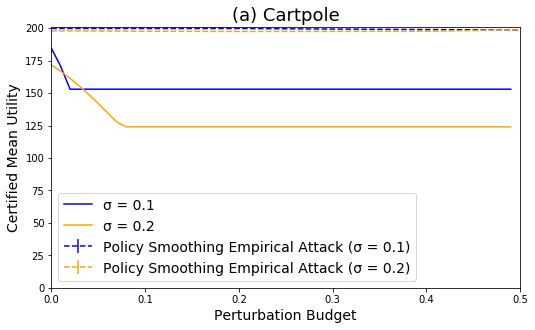

In [21]:

import scipy.special
from scipy.stats import norm, binom_test,sem
from statsmodels.stats.proportion import proportion_confint
import math
import numpy as np
import torch
import matplotlib.pyplot as plt
import cvxpy as cp
import warnings
from sklearn import preprocessing

warnings.filterwarnings("ignore")
def get_cvar_cert_time_t(estimate, t, eps,sigma):
	erf = scipy.special.erf(math.sqrt(t+1) * eps/(2*math.sqrt(2)*sigma))
	cvar = 1. if estimate > erf else estimate/erf
	return cvar * erf

def get_exact_time_t(estimate, t, eps,sigma):
	return norm.cdf(norm.ppf(estimate) - math.sqrt(t+1) * eps/(sigma))

def _lower_confidence_bound(NA: int, N: int, alpha: float) -> float:
    return proportion_confint(NA, N, alpha=2 * alpha, method="beta")[0]
def get_exact_total(estimate, eps,sigma):
	return norm.cdf(norm.ppf(estimate) -  eps/(sigma))

def _hoeffding_lcb(mean: float,  N: int, alpha: float) -> float:
	return max(mean - math.sqrt(math.log(1./alpha)/(2*N)),0)
def get_hs_bound(sigma,norm_bound:float):
        a = norm_bound/(2*np.square(sigma)) -1
        HS_bound = 2*norm.cdf(a)
        return np.abs(HS_bound)



def optimize(epsilon_0: float,  phi,mini,maxi):
    

    
    N=len(phi)
    lambda_0 = cp.Variable(1)
    
    k=cp.Variable(1)
    u_0=cp.maximum(k+lambda_0*epsilon_0-(phi),-lambda_0/2)
    mean=cp.sum(u_0)/N
    
    #for i in range(n_iter):
    prob = k-mean
    cp.Problem(cp.Maximize(prob),[lambda_0>=0,prob>=0,k<=lambda_0*(1/2-epsilon_0)+mini]).solve() #k<=lambda_0*(1-epsilon_0)+min(phi)
    #print(k.value,lambda_0.value,lambda_1.value)
    return  k.value,lambda_0.value
    #return prob.value
def variance(mean,z):
    var=[]
    N=len(z)
    for i in range(N):
        var.append((z[i]-mean)**2)
    final_var=np.sum(var)/N
    return final_var
    
epsilon_PAC=0.01
plt.figure(figsize=(8.4,4.8))
colors = ['blue','orange','cornflowerblue','deepskyblue','cadetblue']
shapes = ['-', '--', '-.', ':']
for j,sigma in enumerate([0.1,0.2]):#0.4,0.6,0.8]):
    data = torch.tensor(torch.load('cartpole_multiframe_sigma_'+str(sigma)+'/best_model.zip_evals_10000.pth'))
    #states=torch.tensor(torch.load('cartpole_multiframe_sigma_'+str(sigma)+'/best_model.zipinitial_state.pth'))
    
    samples=1000
    
    vals = []
    var_our = []
    N=len(data)
    data=data.numpy()
    vals_crop =[]
    for eps in np.arange(0.0,0.5, 0.01):#1.01
        epsilon_0 = get_hs_bound(sigma,norm_bound=eps)
        # bound for beta=8
        avg = 0
        accum = 0
        k,lambda_0=optimize(epsilon_0,data[:samples],min(data),200)
        
        u_0=np.maximum(k+epsilon_0*lambda_0-data,-lambda_0/2)
        #for i in range(n_iter):
        reward = u_0
        ave_reward=np.mean(np.array(reward))
        var=variance(ave_reward,np.array(reward))
        R=max(reward)-min(reward)
        upper_bound_E= ave_reward+math.sqrt(2*var**2*math.log(3/0.01)/N)+3*R*math.log(3/0.01)/N
        result=k-upper_bound_E
        var_our.append(result)
        
        
    
    plt.plot(np.arange(0.00,0.5, 0.01),var_our,color=colors[j],linestyle='-',  label= "σ = " + str(sigma)) 
    


styles = ['-.','--',":"]
attack_mags_nonzero = [0.2,0.4,0.6,0.8,1.0]#
for j,sigma in enumerate([0.1,0.2]):#,0.4]):
    attack_vals =  [torch.tensor(torch.load('cartpole_multiframe_sigma_'+str(sigma)+'/best_model.zip_evals_10000.pth')).float().mean().item()]
    attack_sems = [sem(torch.tensor(torch.load('cartpole_multiframe_sigma_'+str(sigma)+'/best_model.zip_evals_10000.pth')))]
    for attack_mag in attack_mags_nonzero:
        attack_val = None
        attack_sem = None
        for i,thresh in enumerate([0.0]):
            
            cur_val = (torch.tensor( torch.load('cartpole_multiframe_sigma_'+str(sigma)+'/best_model_evals_1000_smooth_attack_l1_eps_'+str(attack_mag)+'_attack_step_count_multiplier_2_attack_step_0.01_threshold_'+str(thresh)+'_num_smoothing_points_128.pth')).float().mean().item())
            if (attack_val is None or cur_val < attack_val):
                attack_val = cur_val
                attack_sem = (sem(torch.tensor( torch.load('cartpole_multiframe_sigma_'+str(sigma)+'/best_model_evals_1000_smooth_attack_l1_eps_'+str(attack_mag)+'_attack_step_count_multiplier_2_attack_step_0.01_threshold_'+str(thresh)+'_num_smoothing_points_128.pth'))))
        attack_vals.append(attack_val)
        attack_sems.append(attack_sem)
    attack_mags = [0] + attack_mags_nonzero
    
    plt.errorbar([x for x in attack_mags],attack_vals,  yerr= attack_sems, color=colors[j],  linestyle='--',label="Policy Smoothing Empirical Attack (σ = " + str(sigma) + ')')
plt.legend(fontsize=14)
plt.title('(a) Cartpole', fontsize=18)
plt.xlim(0,0.5)
plt.xlabel('Perturbation Budget', fontsize=14)
plt.ylim(0,201)
plt.ylabel('Certified Mean Utility', fontsize=14)
plt.savefig('cartpolel1.pdf', dpi=400,bbox_inches='tight')
plt.show()

L2 compare for freeway

0.006108999252319336
ourtime 0.022280876636505128 baseline_time 0.019059884548187255


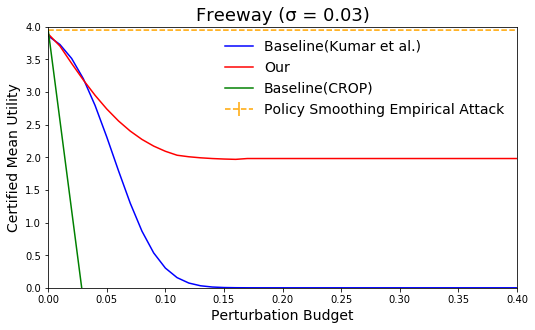

In [30]:

import scipy.special
from scipy.stats import norm, binom_test,sem
from statsmodels.stats.proportion import proportion_confint
import math
import numpy as np
import torch
import matplotlib.pyplot as plt
import cvxpy as cp
import warnings
from sklearn import preprocessing
import time
warnings.filterwarnings("ignore")
def get_cvar_cert_time_t(estimate, t, eps,sigma):
	erf = scipy.special.erf(math.sqrt(t+1) * eps/(2*math.sqrt(2)*sigma))
	cvar = 1. if estimate > erf else estimate/erf
	return cvar * erf

def get_exact_time_t(estimate, t, eps,sigma):
	return norm.cdf(norm.ppf(estimate) - math.sqrt(t+1) * eps/(sigma))

def _lower_confidence_bound(NA: int, N: int, alpha: float) -> float:
    return proportion_confint(NA, N, alpha=2 * alpha, method="beta")[0]
def get_exact_total(estimate, eps,sigma):
	return norm.cdf(norm.ppf(estimate) -  eps/(sigma))

def _hoeffding_lcb(mean: float,  N: int, alpha: float) -> float:
	return max(mean - math.sqrt(math.log(1./alpha)/(2*N)),0)
def get_hs_bound(sigma,norm_bound:float, beta:float):
        
        a = norm_bound/(2*sigma) - np.log(beta)*sigma/(2*norm_bound)
        b = -norm_bound/(2*sigma) - np.log(beta)*sigma/(2*norm_bound)
        HS_bound = norm.cdf(a)-beta*norm.cdf(b)-max(1-beta,0)
        return max(0,HS_bound)



def optimize(epsilon_0: float,  beta_0 : float, phi,min_d):
    
   
    
    N=len(phi)
    lambda_0 = cp.Variable(1)
    
    k=cp.Variable(1)
    u_0=k+lambda_0*epsilon_0-phi
    
    
    f_0_r = cp.sum(cp.maximum(beta_0*u_0,0))/N +lambda_0*cp.maximum(1-beta_0,0)
    
    #for i in range(n_iter):
    prob = k-(f_0_r)
    cp.Problem(cp.Maximize(prob),[lambda_0>=0,prob>=0,k<=lambda_0*(1-epsilon_0)+min(phi)]).solve()#k<=lambda_0*(1-epsilon_0)+min(phi)
    #print(k.value,lambda_0.value,lambda_1.value)
    return  k.value,lambda_0.value
    #return prob.value
def variance(mean,z):
    var=[]
    N=len(z)
    for i in range(N):
        var.append((z[i]-mean)**2)
    final_var=np.sum(var)/N
    return final_var
    
epsilon_PAC=0.01
plt.figure(figsize=(8.4,4.8))
colors = ['blue','cornflowerblue','deepskyblue','cadetblue']
shapes = ['-', '--', '-.', ':']
for j,sigma in enumerate([7.65]):#0.4,12.75 ]):
    
    data = torch.tensor(torch.load('freeway_sigma_'+str(sigma)+'_1/best_model_evals_10000.pth'))
    
    #states=torch.tensor(torch.load('cartpole_multiframe_sigma_'+str(sigma)+'/best_model.zipinitial_state.pth'))
    st1=time.time()
    probs = torch.tensor(list([(data > i).sum()/10000. for i in range(200)]))
    probs_lb = [ _hoeffding_lcb(i,10000, .01/200) for i in probs]
    en1=time.time()-st1
    print(en1)
    
    samples=1000
    #samples=int(2/epsilon_PAC*(np.log(1/0.05)+np.shape(states)[1]))
    
    vals = []
    var_our = []
    N=len(data)
    data=data.numpy()
    vals_crop =[]
    time_our=[]
    time_bs=[]
    for eps in np.arange(0.0*255,1.0*255, 0.01*255):#1.01
        
        
        #if eps<0.05:
        #    beta_0=1
        #elif eps<0.2:
        #    beta_0=1.7
        #else:
        #    beta_0 = 0.5 #1.2 for0.05  
        beta_0=1.1
        
        epsilon_0 = get_hs_bound(sigma,norm_bound=eps,beta=beta_0)
        # bound for beta=8
        avg = 0
        accum = 0
        #var_our.append(optimize(epsilon_0,epsilon_1,beta_0,beta_1,data[:samples]))
        
        start=time.time()
        k,lambda_0=optimize(epsilon_0,beta_0,data[:samples],min(data))
        u_0=k+epsilon_0*lambda_0-data
        f_0_r = np.maximum(beta_0*u_0,0)+ lambda_0*np.maximum(1-beta_0,0)
        #for i in range(n_iter):
        result= k-(np.mean(np.array(f_0_r))+(max(f_0_r)-min(f_0_r))*math.sqrt(math.log(2/0.01)/(2*N)))
        var_our.append(result)
        end=time.time()-start
        time_our.append(end)
        st=time.time()
        
        for i in range(200):
            avg += 0.02*probs[(199-i)]
            
            accum += get_exact_total(probs_lb[(199-i)],eps, sigma)
        en=time.time()-st  
        time_bs.append(en)
        #if (eps == 0.01):
            #vals.append(avg)
            #var_our.append(avg)
        vals.append(accum)
        L=(np.max(data)-np.min(data))/sigma *math.sqrt(2/math.pi)
        crop=np.mean(data)-L*eps*math.sqrt(3)
        vals_crop.append(crop)
    print('ourtime',np.mean(time_our),'baseline_time',np.mean(time_bs))
    plt.plot(np.arange(0.00,1.00, 0.01),vals,color=colors[j],linestyle=shapes[j],  label= "Baseline(Kumar et al.)")  #"Policy Smoothing: Certified\nLower Bound (σ = " + str(sigma) +')')
    plt.plot(np.arange(0.00,1.00, 0.01),var_our,color='red',linestyle=shapes[j],  label= "Our") 
    plt.plot(np.arange(0.00,1.00, 0.01),vals_crop,color='green',linestyle=shapes[j],  label= "Baseline(CROP)")






styles = ['-.','--',":"]
attack_mags_nonzero = [25.5, 51.0]# 76.5,102.0
for j,sigma in enumerate([7.65]):#,7.65 12.75]):
    attack_vals =  [torch.tensor(torch.load('freeway_sigma_'+str(sigma)+'_1/best_model_evals_10000.pth')).float().mean().item()]
    attack_sems = [sem(torch.tensor(torch.load('freeway_sigma_'+str(sigma)+'_1/best_model_evals_10000.pth')))]
    for attack_mag in attack_mags_nonzero:
        attack_val = None
        attack_sem = None
        for i,thresh in enumerate([0.0]):
            cur_val = (torch.tensor( torch.load('freeway_sigma_'+str(sigma)+'_1/best_model_evals_1000_smooth_attack_eps_'+str(attack_mag)+'_attack_step_count_multiplier_2_attack_step_2.5500000000000003_threshold_'+str(thresh)+'_num_smoothing_points_128.pth')).float().mean().item())
            if (attack_val is None or cur_val < attack_val):
                attack_val = cur_val
                attack_sem = (sem(torch.tensor( torch.load('freeway_sigma_'+str(sigma)+'_1/best_model_evals_1000_smooth_attack_eps_'+str(attack_mag)+'_attack_step_count_multiplier_2_attack_step_2.5500000000000003_threshold_'+str(thresh)+'_num_smoothing_points_128.pth'))))
        attack_vals.append(attack_val)
        attack_sems.append(attack_sem)
    attack_mags = [0] + attack_mags_nonzero
    plt.errorbar([x for x in attack_mags],attack_vals,  yerr= attack_sems, color='orange',  linestyle ="--",label="Policy Smoothing Empirical Attack")


plt.legend(fontsize=14,frameon=False)
plt.title('Freeway (σ = 0.03)', fontsize=18)
plt.xlim(0,0.4)
plt.xlabel('Perturbation Budget', fontsize=14)
plt.ylim(0,4)
plt.ylabel('Certified Mean Utility', fontsize=14)
plt.savefig('freeway0.03.pdf', dpi=400,bbox_inches='tight')
plt.show()

L1 for freeway

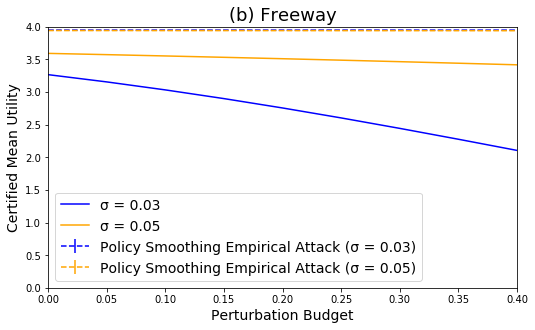

In [31]:

import scipy.special
from scipy.stats import norm, binom_test,sem
from statsmodels.stats.proportion import proportion_confint
import math
import numpy as np
import torch
import matplotlib.pyplot as plt
import cvxpy as cp
import warnings
from sklearn import preprocessing

warnings.filterwarnings("ignore")
def get_cvar_cert_time_t(estimate, t, eps,sigma):
	erf = scipy.special.erf(math.sqrt(t+1) * eps/(2*math.sqrt(2)*sigma))
	cvar = 1. if estimate > erf else estimate/erf
	return cvar * erf

def get_exact_time_t(estimate, t, eps,sigma):
	return norm.cdf(norm.ppf(estimate) - math.sqrt(t+1) * eps/(sigma))

def _lower_confidence_bound(NA: int, N: int, alpha: float) -> float:
    return proportion_confint(NA, N, alpha=2 * alpha, method="beta")[0]
def get_exact_total(estimate, eps,sigma):
	return norm.cdf(norm.ppf(estimate) -  eps/(sigma))

def _hoeffding_lcb(mean: float,  N: int, alpha: float) -> float:
	return max(mean - math.sqrt(math.log(1./alpha)/(2*N)),0)
def get_tv_bound(sigma,norm_bound:float):
        
        a = norm_bound/(2*sigma**2) -1
        
        tv_bound = 2*norm.cdf(a)
        return tv_bound



def optimize(epsilon_0: float,phi,mini,maxi):

    
    N=len(phi)
    lambda_0 = cp.Variable(1)
    
    k=cp.Variable(1)
    u_0=cp.maximum(k+lambda_0*epsilon_0-(phi),-lambda_0/2)
    
    mean=cp.sum(u_0)/N
    
    
    #for i in range(n_iter):
    prob = k-mean
    cp.Problem(cp.Maximize(prob),[lambda_0>=0,prob>=0,k<=lambda_0*(1/2-epsilon_0)+min(phi)]).solve() #k<=lambda_0*(1-epsilon_0)+min(phi)
    #print(k.value,lambda_0.value,lambda_1.value)
    return  k.value,lambda_0.value
    #return prob.value
def variance(mean,z):
    var=[]
    N=len(z)
    for i in range(N):
        var.append((z[i]-mean)**2)
    final_var=np.sum(var)/N
    return final_var
    
epsilon_PAC=0.01
plt.figure(figsize=(8.4,4.8))
colors = ['blue','orange','deepskyblue','cadetblue']
shapes = ['-', '--', '-.', ':']
for j,sigma in enumerate([7.65,12.75]):#0.4,0.6,0.8]):
    data = torch.tensor(torch.load('freeway_sigma_'+str(sigma)+'_1/best_model_evals_10000.pth'))
    #states=torch.tensor(torch.load('cartpole_multiframe_sigma_'+str(sigma)+'/best_model.zipinitial_state.pth'))
    
    samples=1000

    
    vals = []
    var_our = []
    N=len(data)
    data=data.numpy()
    vals_crop =[]
    for eps in np.arange(0*255,0.41*255, 0.05*255):#1.01
        #if sigma==7.65:
         #   epsilon_0 = get_hs_bound(sigma,norm_bound=eps)
        #else:
        epsilon_0 = get_tv_bound(sigma,norm_bound=eps)
        
        # bound for beta=8
        avg = 0
        accum = 0
        #var_our.append(optimize(epsilon_0,epsilon_1,beta_0,beta_1,data[:samples]))
        
        k,lambda_0=optimize(epsilon_0,data[:samples],min(data),max(data))
        
        u_0=np.maximum(k+epsilon_0*lambda_0-data,-lambda_0/2)
        
        #for i in range(n_iter):
        reward = u_0
        ave_reward=np.mean(np.array(reward))
        var=variance(ave_reward,np.array(reward))
        R=max(reward)-min(reward)
        upper_bound_E= ave_reward+R*math.sqrt(math.log(2/0.01)/(2*N))
        #+math.sqrt(2*var**2*math.log(3/0.01)/N)+3*R*math.log(3/0.01)/N
        result=k-upper_bound_E
        var_our.append(result)
        
        
    formatted_sigma = "{:.2f}".format(sigma / 255)
    plt.plot(np.arange(0.00,0.41, 0.05),var_our,color=colors[j],linestyle='-',  label= "σ = " + formatted_sigma) 
    


styles = ['-.','--',":"]
attack_mags_nonzero = [25.5, 51.0, 76.5,102.0]#
for j,sigma in enumerate([7.65,12.75]):#,0.4]):
    attack_vals =  [torch.tensor(torch.load('freeway_sigma_'+str(sigma)+'_1/best_model_evals_10000.pth')).float().mean().item()]
    attack_sems = [sem(torch.tensor(torch.load('freeway_sigma_'+str(sigma)+'_1/best_model_evals_10000.pth')))]
    for attack_mag in attack_mags_nonzero:
        attack_val = None
        attack_sem = None
        for i,thresh in enumerate([0.12]):
            cur_val = (torch.tensor( torch.load('freeway_sigma_'+str(sigma)+'_1/best_model_evals_1000_smooth_attackl1_eps_'+str(attack_mag)+'_attack_step_count_multiplier_2_attack_step_2.5500000000000003_threshold_'+str(thresh)+'_num_smoothing_points_128.pth')).float().mean().item())
            if (attack_val is None or cur_val < attack_val):
                attack_val = cur_val
                attack_sem = (sem(torch.tensor( torch.load('freeway_sigma_'+str(sigma)+'_1/best_model_evals_1000_smooth_attackl1_eps_'+str(attack_mag)+'_attack_step_count_multiplier_2_attack_step_2.5500000000000003_threshold_'+str(thresh)+'_num_smoothing_points_128.pth'))))
        attack_vals.append(attack_val)
        attack_sems.append(attack_sem)
    attack_mags = [0] + attack_mags_nonzero
    formatted_sigma = "{:.2f}".format(sigma / 255)
    plt.errorbar([x for x in attack_mags],attack_vals,  yerr= attack_sems, color=colors[j],  linestyle ="--",label="Policy Smoothing Empirical Attack (σ = " + formatted_sigma+')')
    
    
plt.legend(fontsize=14)
plt.title('(b) Freeway', fontsize=18)
plt.xlim(0,0.4)
plt.xlabel('Perturbation Budget', fontsize=14)
plt.ylim(0,4)
plt.ylabel('Certified Mean Utility', fontsize=14)
plt.savefig('freewayl1.pdf', dpi=400,bbox_inches='tight')
plt.show()

Freeway L0

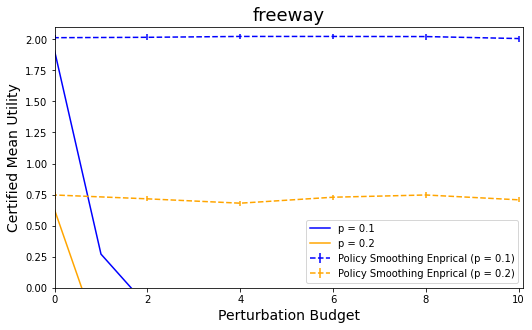

In [2]:

import scipy.special
from scipy.stats import norm, binom_test,sem
from statsmodels.stats.proportion import proportion_confint
import math
import numpy as np
import torch
import matplotlib.pyplot as plt
import cvxpy as cp
import warnings
from sklearn import preprocessing
from scipy.interpolate import interp1d
#from nevergrad.optimization import optimizerlib
from scipy.ndimage import gaussian_filter1d
warnings.filterwarnings("ignore")
def get_cvar_cert_time_t(estimate, t, eps,sigma):
	erf = scipy.special.erf(math.sqrt(t+1) * eps/(2*math.sqrt(2)*sigma))
	cvar = 1. if estimate > erf else estimate/erf
	return cvar * erf

def get_exact_time_t(estimate, t, eps,sigma):
	return norm.cdf(norm.ppf(estimate) - math.sqrt(t+1) * eps/(sigma))

def _lower_confidence_bound(NA: int, N: int, alpha: float) -> float:
    return proportion_confint(NA, N, alpha=2 * alpha, method="beta")[0]
def get_exact_total(estimate, eps,sigma):
	return norm.cdf(norm.ppf(estimate) -  eps/(sigma))

def _hoeffding_lcb(mean: float,  N: int, alpha: float) -> float:
	return max(mean - math.sqrt(math.log(1./alpha)/(2*N)),0)
def get_hs_bound(p:float,norm_bound:float, a:float,n:int):

  q=1-p
  hs1=p*(q/((n-1)*p))**a
  hs2= hs1+(q/(n-1))*((n-1)*p/q)**a+(n-2)/(n-1)*q
  hs=np.log(hs2)/(a-1)
  return hs*norm_bound
import numpy as np

from scipy.optimize import minimize, LinearConstraint
def optimize_new(epsilon_0: float,  beta_0 : float, phi,minim):
    N=len(phi)
    lambda_0 = cp.Variable(1)
    
    
    k=cp.Variable(1)
    u_0=k+lambda_0*epsilon_0-(phi)
    
    
    f_0_r = cp.maximum(beta_0*u_0,0)+ lambda_0*cp.maximum(1-beta_0,0)
    mean=cp.sum(f_0_r)/N
    r=mean
    
    #for i in range(n_iter):
    prob = k-r
    cp.Problem(cp.Maximize(prob),[lambda_0>=0,prob>=0,k<=lambda_0*(1-epsilon_0)+minim]).solve(solver=cp.ECOS) #k<=lambda_0*(1-epsilon_0)+min(phi)
    #print(k.value,lambda_0.value,lambda_1.value)
    return  k.value,lambda_0.value
    #return prob.value
def objective(x, beta_0,epsilon_0, phi, N):
    lambda_0, b= x
    if beta_0<1:
      f_0_r = (b*lambda_0 + lambda_0 * epsilon_0 - phi)
      h = (f_0_r / -beta_0) ** (beta_0 / (beta_0 - 1))
      f = -lambda_0 + (lambda_0 ** (1 / 1-beta_0))*(1-beta_0) * h
      r = np.sum(f) / N
      prob = b * lambda_0 - r
    else:
      u_0 = (b*lambda_0 + lambda_0 * epsilon_0 - phi)
      f_0_r = np.maximum(u_0, 0)
      h = (f_0_r / beta_0) ** (beta_0 / (beta_0 - 1))
      f = lambda_0 + (lambda_0 ** (1 / 1-beta_0))*(beta_0 - 1) * h
      R=np.max(f)-np.min(f)
      r=(np.mean(np.array(f))+(R)*math.sqrt(math.log(2/0.01)/(2*N)))
      #r = np.sum(f) / N
      prob = b * lambda_0 - r
    return -prob  # Minimize the negative of the objective for maximization

def optimize(epsilon_0, phi, initial_guess,beta_0):
    N = len(phi)
      # 0.5, 5 #0.1,1
    bounds = [(0,4), (-4, 4)]  # Bounds for lambda_0, b, and beta_0  #np.min(phi)/(initial_guess[1]+epsilon_0)
    
    
    # Perform optimization with the initial guess
    result = minimize(objective, initial_guess, args=(beta_0,epsilon_0, np.array(phi), N), bounds=bounds, method='L-BFGS-B')# CG L-BFGS-B

    # Iteratively refine the initial guess until the objective is close to the target_prob
    optimal_lambda_0, optimal_b = result.x
    return optimal_lambda_0, optimal_b
def variance(mean,z):
    var=[]
    N=len(z)
    for i in range(N):
        var.append((z[i]-mean)**2)
    final_var=np.sum(var)/N
    return final_var  
epsilon_PAC=0.01
plt.figure(figsize=(8.4,4.8))
colors = ['blue','orange','cornflowerblue','deepskyblue','cadetblue']
shapes = ['-', '--', '-.', ':']
for j,p in enumerate([0.1,0.2]):#0.4,0.6,0.8]):
    data = torch.tensor(torch.load('freeway_ef_'+str(p)+'/best_model_evals_10000.pth'))
    #states=torch.tensor(torch.load('cartpole_multiframe_sigma_'+str(sigma)+'/best_model.zipinitial_state.pth'))
    

    
    samples=4000
    
    #samples=int(2/epsilon_PAC*(np.log(1/0.05)+np.shape(states)[1]))
    
    vals = []
    var_our = []
    N=len(data)
    data=data.numpy()
    vals_crop =[]
    for eps in np.arange(0.0,11.0, 1.0):#1.01
        if p==0.1:
          beta_0=2#2.15
          initial_guess = [0.3,2.2]
        else:
          beta_0=2#2.15
          initial_guess = [0.5,1.5]
        
        
        epsilon_0 = get_hs_bound(1-p,eps,beta_0,3)
        
        # bound for beta=8
        avg = 0
        accum = 0
        
        #var_our.append(optimize(epsilon_0,epsilon_1,beta_0,beta_1,data[:samples]))
        
        lambda_0,k=optimize(epsilon_0,data[:samples],initial_guess,beta_0)
        #print(lambda_0,k,beta_0)
        if beta_0<1:
          f_0_r = (k*lambda_0 + lambda_0 * epsilon_0 - data)
          h = (f_0_r / -beta_0) ** (beta_0 / (beta_0 - 1))
          f = -lambda_0 + (lambda_0 ** (1 / 1-beta_0))*(1-beta_0) * h
        else:
          u_0 = (k*lambda_0 + lambda_0 * epsilon_0 - data)
          f_0_r = np.maximum(u_0, 0)
          
          h = (f_0_r / beta_0) ** (beta_0 / (beta_0 - 1))
          #print(h)
          f = lambda_0 + (lambda_0 ** (1 / 1-beta_0))*(beta_0 -1) * h
        #for i in range(n_iter):
        reward = f
        ave_reward=np.mean(np.array(reward))
        
        var=variance(ave_reward,np.array(reward))
        R=max(reward)-min(reward)
        
        upper_bound_E= ave_reward+(R)*math.sqrt(math.log(2/0.01)/(2*N))#+math.sqrt(2*var**2*math.log(3/0.01)/N)+3*R*math.log(3/0.01)/N
        result=k*lambda_0-upper_bound_E
        #print(result)
        var_our.append(result)

    
    #y=gaussian_filter1d(var_our, sigma=0.4) #var_our
    plt.plot(np.arange(0.00,11.0, 1.0),var_our,color=colors[j],linestyle='-',  label= "p = " + str(p)) 
    


styles = ['-.','--',":"]
attack_mags_nonzero = [0.0,2.0,4.0,6.0,8.0,10.0]#20.0,30.0,40.0,50.0
for j,p in enumerate([0.1,0.2]):#,0.4]):
    
    attack_vals =  [torch.tensor(torch.load('freeway_ef_'+str(p)+'/best_model_evals_10000.pth')).float().mean().item()]
    attack_sems = [sem(torch.tensor(torch.load('freeway_ef_'+str(p)+'/best_model_evals_10000.pth')))]
    for attack_mag in attack_mags_nonzero:
        attack_val = None
        attack_sem = None
        for i,thresh in enumerate([0.0]):
			
            cur_val = (torch.tensor( torch.load('freeway_ef_'+str(p)+'/best_model.zip_evals_1000_smooth_attackl0_eps_'+str(attack_mag)+'_attack_step_count_multiplier_2_attack_step_2.5500000000000003_threshold_0.0_num_smoothing_points_128.pth')).float().mean().item())
            if (attack_val is None or cur_val < attack_val):
                attack_val = cur_val
                attack_sem = (sem(torch.tensor( torch.load('freeway_ef_'+str(p)+'/best_model.zip_evals_1000_smooth_attackl0_eps_'+str(attack_mag)+'_attack_step_count_multiplier_2_attack_step_2.5500000000000003_threshold_'+str(thresh)+'_num_smoothing_points_128.pth'))))
        attack_vals.append(attack_val)
        attack_sems.append(attack_sem)
    attack_mags = [0] + attack_mags_nonzero
    
    plt.errorbar([x for x in attack_mags],attack_vals,  yerr= attack_sems, color=colors[j],  linestyle ='--',label="Policy Smoothing Enprical (p = " + str(p) + ')') 
plt.legend()
plt.title('freeway', fontsize=18)
plt.xlim(0,10.1)
plt.xlabel('Perturbation Budget', fontsize=14)
plt.ylim(0,2.1)
plt.ylabel('Certified Mean Utility', fontsize=14)
plt.savefig('freeway_certsl0.png', dpi=400,bbox_inches='tight')
plt.show()

L2 compare for Mountain car

tensor([1, 1, 1,  ..., 1, 1, 1])


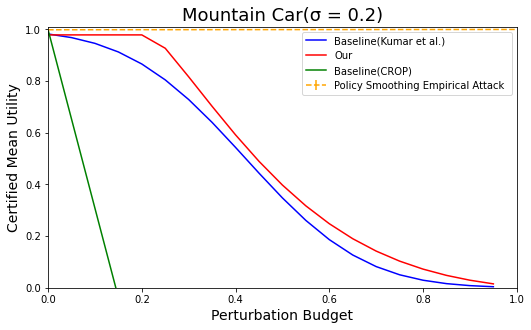

In [6]:
import scipy.special
from scipy.stats import norm, binom_test,sem
from statsmodels.stats.proportion import proportion_confint
import math
import numpy as np
import torch
import matplotlib.pyplot as plt
import cvxpy as cp
import warnings
from sklearn import preprocessing

warnings.filterwarnings("ignore")
def get_cvar_cert_time_t(estimate, t, eps,sigma):
	erf = scipy.special.erf(math.sqrt(t+1) * eps/(2*math.sqrt(2)*sigma))
	cvar = 1. if estimate > erf else estimate/erf
	return cvar * erf

def get_exact_time_t(estimate, t, eps,sigma):
	return norm.cdf(norm.ppf(estimate) - math.sqrt(t+1) * eps/(sigma))

def _lower_confidence_bound(NA: int, N: int, alpha: float) -> float:
    return proportion_confint(NA, N, alpha=2 * alpha, method="beta")[0]
def get_exact_total(estimate, eps,sigma):
	return norm.cdf(norm.ppf(estimate) -  eps/(sigma))

def _hoeffding_lcb(mean: float,  N: int, alpha: float) -> float:
	return max(mean - math.sqrt(math.log(1./alpha)/(2*N)),0)
def get_hs_bound(sigma,norm_bound:float, beta:float):
        
        a = norm_bound/(2*sigma) - np.log(beta)*sigma/(2*norm_bound)
        b = -norm_bound/(2*sigma) - np.log(beta)*sigma/(2*norm_bound)
        HS_bound = norm.cdf(a)-beta*norm.cdf(b)-max(1-beta,0)
        return max(0,HS_bound)


plt.figure(figsize=(8.4,4.8))
def optimize(epsilon_0: float,  beta_0 : float, phi,mini):
    N=len(phi)
    lambda_0 = cp.Variable(1)
    
    k=cp.Variable(1)
    u_0=k+lambda_0*epsilon_0-phi
    
    
    f_0_r = cp.sum(cp.maximum(beta_0*u_0,0))/N + lambda_0*cp.maximum(1-beta_0,0)
    
    #for i in range(n_iter):
    prob = k-f_0_r
    cp.Problem(cp.Maximize(prob),[lambda_0>=0,prob>=0,k<=lambda_0*(1-epsilon_0)+mini]).solve()
    #print(k.value,lambda_0.value,lambda_1.value)
    return  k.value,lambda_0.value
    #return prob.value
def variance(mean,z):
    var=[]
    N=len(z)
    for i in range(N):
        var.append((z[i]-mean)**2)
    final_var=np.sum(var)/N
    return final_var   
epsilon_PAC=0.01
colors = ['blue','cornflowerblue','deepskyblue','cadetblue']
shapes = ['-', '--', '-.', ':']
for j,sigma in enumerate([0.2]):#0.4,0.6,0.8]):
    data = torch.tensor(torch.load('mountain_car_sigma_'+str(sigma)+'/best_model_evals_10000.pth'))
    print(data)
    #states=torch.tensor(torch.load('mountain_car_sigma_'+str(sigma)+'/best_modelinitial_state.pth'))
    prob = torch.tensor(data).float().mean()
    #lcb = _lower_confidence_bound(int(prob*10000), 10000, 0.05)
    lcb =_hoeffding_lcb(prob,10000, .01/2)
    samples=1000
    vals = []
    var_our = []
    N=len(data)
    data=data.numpy()
    vals_crop=[]
    for eps in np.arange(0.00,1.0,0.05):
        vals.append(get_exact_total(lcb,eps,sigma))
        if p==0.2:
          beta_0=4
        else:
          if eps <0.2:
            beta_0 = 1# for 0.2
          elif eps<0.6:
            beta_0=0.7
          else:
            beta_0 =0.2
        
        epsilon_0 = get_hs_bound(sigma,norm_bound=eps,beta=beta_0)
        # bound for beta=8
        avg = 0
        accum = 0
        #var_our.append(optimize(epsilon_0,epsilon_1,beta_0,beta_1,data[:samples]))
        k,lambda_0=optimize(epsilon_0,beta_0,data[:samples],min(data))
        u_0=k+lambda_0*epsilon_0-data
        f_0_r = np.maximum(beta_0*u_0,0) + lambda_0*np.maximum(1-beta_0,0)
        #for i in range(n_iter):
        reward = f_0_r
        ave_reward=np.mean(np.array(reward))
        #var=variance(ave_reward,np.array(reward))
        R=max(reward)-np.minimum(min(reward),0)
        upper_bound_E= ave_reward+np.sqrt(1/(2*10000)*np.log(2/0.01))
        result= k-upper_bound_E
        #result=k-(np.mean(np.array(f_0_r))+(R)*math.sqrt(math.log(2/0.01)/(2*N)))
        var_our.append(result)
        L=(np.max(data)-np.min(data))/sigma *math.sqrt(2/math.pi)
        crop=np.mean(data)-L*eps*math.sqrt(3)
        vals_crop.append(crop)
    plt.plot(np.arange(0.0,1.0,0.05),vals, color=('blue' ), linestyle=('-') ,label="Baseline(Kumar et al.)")#"Policy Smoothing: Certified\nLower Bound (σ = " + str(sigma) +')')
    plt.plot(np.arange(0.00,1.0, 0.05),var_our,color='red',linestyle=shapes[j],  label= "Our") 
    plt.plot(np.arange(0.00,1.00, 0.05),vals_crop,color='green',linestyle=shapes[j],  label= "Baseline(CROP)")

styles = ['-.','--',":"]
attack_mags_nonzero = [1.,2.,3.,4.]
for j,sigma in enumerate([0.2]):#,0.4]):
	attack_vals =  [torch.tensor(torch.load('mountain_car_sigma_'+str(sigma)+'/best_model_evals_10000.pth')).float().mean().item()]
	attack_sems = [sem(torch.tensor(torch.load('mountain_car_sigma_'+str(sigma)+'/best_model_evals_10000.pth')))]
	for attack_mag in attack_mags_nonzero:
		attack_val = None
		attack_sem = None
		for i,thresh in enumerate([0.001]):#0.001,0.0001,0.00001
			cur_val = (torch.tensor( torch.load('mountain_car_sigma_'+str(sigma)+'/best_model_smooth_evals_250_attack_eps_'+str(attack_mag)+'_steps_100_attack_step_0.01_threshold_'+str(thresh)+'_num_smoothing_points_128.pth')).float().mean().item())
			if (attack_val is None or cur_val < attack_val):
				attack_val = cur_val
				attack_sem = (sem(torch.tensor( torch.load('mountain_car_sigma_'+str(sigma)+'/best_model_smooth_evals_250_attack_eps_'+str(attack_mag)+'_steps_100_attack_step_0.01_threshold_'+str(thresh)+'_num_smoothing_points_128.pth'))))
		attack_vals.append(attack_val)
		attack_sems.append(attack_sem)
	attack_mags = [0] + attack_mags_nonzero
	plt.errorbar([x for x in attack_mags],attack_vals,  yerr= attack_sems, color='orange',  linestyle ="--",label="Policy Smoothing Empirical Attack ")
plt.legend()
plt.title('Mountain Car(σ = 0.2)', fontsize=18)
plt.xlim(0,1.)
plt.xlabel('Perturbation Budget', fontsize=14)
plt.ylim(0,1.01)
plt.ylabel('Certified Mean Utility', fontsize=14)
plt.savefig('cartpole_multiframe_certs.png', dpi=400,bbox_inches='tight')
plt.show()

L1 For Mountain Car

tensor([1, 1, 1,  ..., 1, 1, 1])


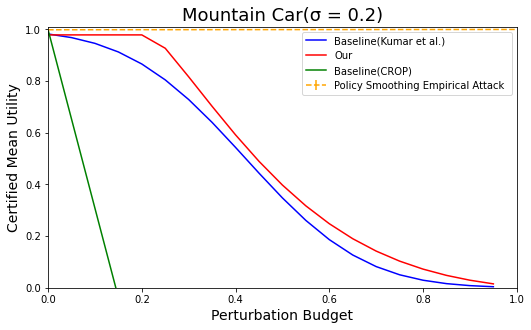

In [2]:
import scipy.special
from scipy.stats import norm, binom_test,sem
from statsmodels.stats.proportion import proportion_confint
import math
import numpy as np
import torch
import matplotlib.pyplot as plt
import cvxpy as cp
import warnings
from sklearn import preprocessing

warnings.filterwarnings("ignore")
def get_cvar_cert_time_t(estimate, t, eps,sigma):
	erf = scipy.special.erf(math.sqrt(t+1) * eps/(2*math.sqrt(2)*sigma))
	cvar = 1. if estimate > erf else estimate/erf
	return cvar * erf

def get_exact_time_t(estimate, t, eps,sigma):
	return norm.cdf(norm.ppf(estimate) - math.sqrt(t+1) * eps/(sigma))

def _lower_confidence_bound(NA: int, N: int, alpha: float) -> float:
    return proportion_confint(NA, N, alpha=2 * alpha, method="beta")[0]
def get_exact_total(estimate, eps,sigma):
	return norm.cdf(norm.ppf(estimate) -  eps/(sigma))

def _hoeffding_lcb(mean: float,  N: int, alpha: float) -> float:
	return max(mean - math.sqrt(math.log(1./alpha)/(2*N)),0)
def get_hs_bound(sigma,norm_bound:float, beta:float):
        
        a = norm_bound/(2*sigma) - np.log(beta)*sigma/(2*norm_bound)
        b = -norm_bound/(2*sigma) - np.log(beta)*sigma/(2*norm_bound)
        HS_bound = norm.cdf(a)-beta*norm.cdf(b)-max(1-beta,0)
        return max(0,HS_bound)


plt.figure(figsize=(8.4,4.8))
def optimize(epsilon_0: float,  beta_0 : float, phi,mini):

    N=len(phi)
    lambda_0 = cp.Variable(1)
    
    k=cp.Variable(1)
    u_0=k+lambda_0*epsilon_0-phi
    
    
    f_0_r = cp.sum(cp.maximum(beta_0*u_0,0))/N + lambda_0*cp.maximum(1-beta_0,0)
    
    #for i in range(n_iter):
    prob = k-f_0_r
    cp.Problem(cp.Maximize(prob),[lambda_0>=0,prob>=0,k<=lambda_0*(1-epsilon_0)+mini]).solve()
    #print(k.value,lambda_0.value,lambda_1.value)
    return  k.value,lambda_0.value
    #return prob.value
def variance(mean,z):
    var=[]
    N=len(z)
    for i in range(N):
        var.append((z[i]-mean)**2)
    final_var=np.sum(var)/N
    return final_var   
epsilon_PAC=0.01
colors = ['blue','cornflowerblue','deepskyblue','cadetblue']
shapes = ['-', '--', '-.', ':']
for j,sigma in enumerate([0.2]):#0.4,0.6,0.8]):
    data = torch.tensor(torch.load('mountain_car_sigma_'+str(sigma)+'/best_model_evals_10000.pth'))
    print(data)
    #states=torch.tensor(torch.load('mountain_car_sigma_'+str(sigma)+'/best_modelinitial_state.pth'))
    prob = torch.tensor(data).float().mean()
    #lcb = _lower_confidence_bound(int(prob*10000), 10000, 0.05)
    lcb =_hoeffding_lcb(prob,10000, .01/2)
    samples=1000
    vals = []
    var_our = []
    N=len(data)
    data=data.numpy()
    vals_crop=[]
    for eps in np.arange(0.00,1.0,0.05):
        vals.append(get_exact_total(lcb,eps,sigma))
        beta_0=4
        '''
        if eps <0.2:
            beta_0 = 1# for 0.2
        elif eps<0.6:
            beta_0=0.7
        else:
            beta_0 =0.2
        '''
        epsilon_0 = get_hs_bound(sigma,norm_bound=eps,beta=beta_0)
        # bound for beta=8
        avg = 0
        accum = 0
        #var_our.append(optimize(epsilon_0,epsilon_1,beta_0,beta_1,data[:samples]))
        k,lambda_0=optimize(epsilon_0,beta_0,data[:samples],min(data))
        u_0=k+lambda_0*epsilon_0-data
        f_0_r = np.maximum(beta_0*u_0,0) + lambda_0*np.maximum(1-beta_0,0)
        #for i in range(n_iter):
        reward = f_0_r
        ave_reward=np.mean(np.array(reward))
        #var=variance(ave_reward,np.array(reward))
        R=max(reward)-np.minimum(min(reward),0)
        upper_bound_E= ave_reward+np.sqrt(1/(2*10000)*np.log(2/0.01))
        result= k-upper_bound_E
        #result=k-(np.mean(np.array(f_0_r))+(R)*math.sqrt(math.log(2/0.01)/(2*N)))
        var_our.append(result)
        L=(np.max(data)-np.min(data))/sigma *math.sqrt(2/math.pi)
        crop=np.mean(data)-L*eps*math.sqrt(3)
        vals_crop.append(crop)
    plt.plot(np.arange(0.0,1.0,0.05),vals, color=('blue' ), linestyle=('-') ,label="Baseline(Kumar et al.)")#"Policy Smoothing: Certified\nLower Bound (σ = " + str(sigma) +')')
    plt.plot(np.arange(0.00,1.0, 0.05),var_our,color='red',linestyle=shapes[j],  label= "Our") 
    plt.plot(np.arange(0.00,1.00, 0.05),vals_crop,color='green',linestyle=shapes[j],  label= "Baseline(CROP)")

styles = ['-.','--',":"]
attack_mags_nonzero = [1.,2.,3.,4.]
for j,sigma in enumerate([0.2]):#,0.4]):
	attack_vals =  [torch.tensor(torch.load('mountain_car_sigma_'+str(sigma)+'/best_model_evals_10000.pth')).float().mean().item()]
	attack_sems = [sem(torch.tensor(torch.load('mountain_car_sigma_'+str(sigma)+'/best_model_evals_10000.pth')))]
	for attack_mag in attack_mags_nonzero:
		attack_val = None
		attack_sem = None
		for i,thresh in enumerate([0.001]):#0.001,0.0001,0.00001
			cur_val = (torch.tensor( torch.load('mountain_car_sigma_'+str(sigma)+'/best_model_smooth_evals_250_attack_eps_'+str(attack_mag)+'_steps_100_attack_step_0.01_threshold_'+str(thresh)+'_num_smoothing_points_128.pth')).float().mean().item())
			if (attack_val is None or cur_val < attack_val):
				attack_val = cur_val
				attack_sem = (sem(torch.tensor( torch.load('mountain_car_sigma_'+str(sigma)+'/best_model_smooth_evals_250_attack_eps_'+str(attack_mag)+'_steps_100_attack_step_0.01_threshold_'+str(thresh)+'_num_smoothing_points_128.pth'))))
		attack_vals.append(attack_val)
		attack_sems.append(attack_sem)
	attack_mags = [0] + attack_mags_nonzero
	plt.errorbar([x for x in attack_mags],attack_vals,  yerr= attack_sems, color='orange',  linestyle ="--",label="Policy Smoothing Empirical Attack ")
plt.legend()
plt.title('Mountain Car(σ = 0.2)', fontsize=18)
plt.xlim(0,1.)
plt.xlabel('Perturbation Budget', fontsize=14)
plt.ylim(0,1.01)
plt.ylabel('Certified Mean Utility', fontsize=14)
plt.savefig('cartpole_multiframe_certs.png', dpi=400,bbox_inches='tight')
plt.show()

tensor([1, 1, 1,  ..., 1, 1, 1])
tensor([0, 1, 0,  ..., 0, 1, 1])


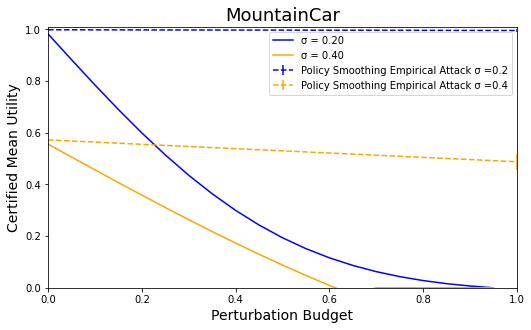

In [7]:

import scipy.special
from scipy.stats import norm, binom_test,sem
from statsmodels.stats.proportion import proportion_confint
import math
import numpy as np
import torch
import matplotlib.pyplot as plt
import cvxpy as cp
import warnings
from sklearn import preprocessing

warnings.filterwarnings("ignore")
def get_cvar_cert_time_t(estimate, t, eps,sigma):
	erf = scipy.special.erf(math.sqrt(t+1) * eps/(2*math.sqrt(2)*sigma))
	cvar = 1. if estimate > erf else estimate/erf
	return cvar * erf

def get_exact_time_t(estimate, t, eps,sigma):
	return norm.cdf(norm.ppf(estimate) - math.sqrt(t+1) * eps/(sigma))

def _lower_confidence_bound(NA: int, N: int, alpha: float) -> float:
    return proportion_confint(NA, N, alpha=2 * alpha, method="beta")[0]
def get_exact_total(estimate, eps,sigma):
	return norm.cdf(norm.ppf(estimate) -  eps/(sigma))

def _hoeffding_lcb(mean: float,  N: int, alpha: float) -> float:
	return max(mean - math.sqrt(math.log(1./alpha)/(2*N)),0)
def get_tv_bound(sigma,norm_bound:float):
        
        a = norm_bound/(2*sigma)
        
        tv_bound = 2*norm.cdf(a)-1
        return tv_bound



def optimize(epsilon_0: float,phi,mini,maxi):
    
    #phi = phi.value_counts()   # 计数
    #phi.sort_index(inplace=True)
    #D=np.shape(states)[1]
    #K=D+1
    #val_l=200
    #val_u=(-200)

    #val=cp.Variable(K)
    #eps = cp.Variable(1)
    
    #new_s@c_val - out<= eps, out-new_s@c_val <= eps, eps >= 0
    
    N=len(phi)
    lambda_0 = cp.Variable(1)
    
    k=cp.Variable(1)
    u_0=cp.maximum(k+lambda_0*epsilon_0-(phi),-lambda_0/2)
    
    mean=cp.sum(u_0)/N
    
    
    #for i in range(n_iter):
    prob = k-mean
    cp.Problem(cp.Maximize(prob),[lambda_0>=0,prob>=0,k<=lambda_0*(1/2-epsilon_0)+mini]).solve() #k<=lambda_0*(1-epsilon_0)+min(phi)
    #print(k.value,lambda_0.value,lambda_1.value)
    return  k.value,lambda_0.value
    #return prob.value
def variance(mean,z):
    var=[]
    N=len(z)
    for i in range(N):
        var.append((z[i]-mean)**2)
    final_var=np.sum(var)/N
    return final_var
    

plt.figure(figsize=(8.4,4.8))
colors = ['blue','orange','cornflowerblue','deepskyblue','cadetblue']
shapes = ['-', '--', '-.', ':']
for j,sigma in enumerate([0.2,0.4]):#0.4,0.6,0.8]):
    data = torch.tensor(torch.load('mountain_car_sigma_'+str(sigma)+'/best_model_evals_10000.pth'))
    #states=torch.tensor(torch.load('cartpole_multiframe_sigma_'+str(sigma)+'/best_model.zipinitial_state.pth'))
    samples=1000
    print(data)

    
    vals = []
    var_our = []
    N=len(data)
    data=data.numpy()
    vals_crop =[]
    for eps in np.arange(0,1.0, 0.05):#1.01
        #if sigma==7.65:
         #   epsilon_0 = get_hs_bound(sigma,norm_bound=eps)
        #else:
        epsilon_0 = get_tv_bound(sigma,norm_bound=eps)
        
        # bound for beta=8
        avg = 0
        accum = 0
        #var_our.append(optimize(epsilon_0,epsilon_1,beta_0,beta_1,data[:samples]))
        
        k,lambda_0=optimize(epsilon_0,data[:samples],min(data),max(data))
        
        u_0=np.maximum(k+epsilon_0*lambda_0-data,-lambda_0/2)
        
        #for i in range(n_iter):
        reward = u_0
        ave_reward=np.mean(np.array(reward))
        var=variance(ave_reward,np.array(reward))
        R=max(reward)-min(reward)
        upper_bound_E= ave_reward+R*math.sqrt(math.log(2/0.01)/(2*N))
        
        result=k-upper_bound_E
        var_our.append(result)
        
        
    formatted_sigma = "{:.2f}".format(sigma)
    plt.plot(np.arange(0.00,1.0, 0.05),var_our,color=colors[j],linestyle='-',  label= "σ = " + formatted_sigma) 
    

'''
attack_mags_nonzero = [0.2,0.4,0.6,0.8,1.0]

attack_vals =  [torch.tensor(torch.load('cartpole_multiframe_sigma_0.0/best_model.zip_evals_10000.pth')).float().mean().item()]
attack_sems = [sem(torch.tensor(torch.load('cartpole_multiframe_sigma_0.0/best_model.zip_evals_10000.pth')))]
for attack_mag in attack_mags_nonzero:
	attack_val = None
	attack_sem = None
	for i,thresh in enumerate([4.,6.,8.,10.]):
		cur_val = (torch.tensor( torch.load('cartpole_multiframe_sigma_0.0/best_model.zip_evals_1000_eps_'+str(attack_mag)+'_attack_step_count_multiplier_2_attack_step_0.01_threshold_'+str(thresh)+'.pth')).float().mean().item())
		if (attack_val is None or cur_val < attack_val):
			attack_val = cur_val
			attack_sem = (sem(torch.tensor( torch.load('cartpole_multiframe_sigma_0.0/best_model.zip_evals_1000_eps_'+str(attack_mag)+'_attack_step_count_multiplier_2_attack_step_0.01_threshold_'+str(thresh)+'.pth'))))
	attack_vals.append(attack_val)
	attack_sems.append(attack_sem)
attack_mags = [0] + attack_mags_nonzero
plt.errorbar([x for x in attack_mags],attack_vals,  yerr= attack_sems, color='red',  linestyle ="--",label="Undefended"  )

'''

styles = ['-.','--',":"]
attack_mags_nonzero = [1.,2.,3.,4.]
for j,sigma in enumerate([0.2,0.4]):#,0.4]):
	attack_vals =  [torch.tensor(torch.load('mountain_car_sigma_'+str(sigma)+'/best_model_evals_10000.pth')).float().mean().item()]
	attack_sems = [sem(torch.tensor(torch.load('mountain_car_sigma_'+str(sigma)+'/best_model_evals_10000.pth')))]
	for attack_mag in attack_mags_nonzero:
		attack_val = None
		attack_sem = None
		for i,thresh in enumerate([0.001]):#0.001,0.0001,0.00001
			cur_val = (torch.tensor( torch.load('mountain_car_sigma_'+str(sigma)+'/best_model_smooth_evals_250_attackl1_eps_'+str(attack_mag)+'_steps_100_attack_step_0.01_threshold_'+str(thresh)+'_num_smoothing_points_128.pth')).float().mean().item())
			if (attack_val is None or cur_val < attack_val):
				attack_val = cur_val
				attack_sem = (sem(torch.tensor( torch.load('mountain_car_sigma_'+str(sigma)+'/best_model_smooth_evals_250_attackl1_eps_'+str(attack_mag)+'_steps_100_attack_step_0.01_threshold_'+str(thresh)+'_num_smoothing_points_128.pth'))))
		attack_vals.append(attack_val)
		attack_sems.append(attack_sem)
	attack_mags = [0] + attack_mags_nonzero
	plt.errorbar([x for x in attack_mags],attack_vals,  yerr= attack_sems, color=colors[j],  linestyle ="--",label="Policy Smoothing Empirical Attack σ ="+str(sigma))


    
plt.legend()
plt.title('MountainCar', fontsize=18)
plt.xlim(0,1)
plt.xlabel('Perturbation Budget', fontsize=14)
plt.ylim(0,1.01)
plt.ylabel('Certified Mean Utility', fontsize=14)
plt.savefig('cartpole_multiframe_certs.pdf', dpi=400,bbox_inches='tight')
plt.show()